# Introduction
Note: this tutorial needs to be updated - some parts may not reflect the usage of Distributios in the master branch.
We use instances of the `Distribution` class to represent information about the set of coefficients required by each module. This information includes:

* Boundaries for the coefficient. For example, the Normal distribution can take on any value. The Beta distribution is bounded by 0 and 1, and the Gamma distribution must be a positive value.

* The expected value of the coefficient. This can be used as the starting point for the fitter.

* The range of probable values. For example, a Normal distribution centered at 10 with a standard deviation of 1 suggests that the coefficient represented by that distribution is very unlikely to have a value of 0 or 100.

A coefficient can be multidimensional. For example, the FIR filter coefficient is a two dimensional array with the shape determined by the number of inputs and the number of taps of the FIR filter. As shown below, the distributions also support specifying multidimensional information.

In [1]:
%matplotlib inline

import numpy as np
import pylab as pl

np.set_printoptions(precision=2)

from nems.distributions.api import Normal, HalfNormal, Gamma, Beta, Uniform
from nems.model import Model
from nems.modules.api import WeightChannelsGaussian, FIR

# Create some fake data that will be used to generate the priors
signals = {
    'pred': np.zeros((18, 10000))
}

# Specifying distributions

Distributions can represent a single coefficient

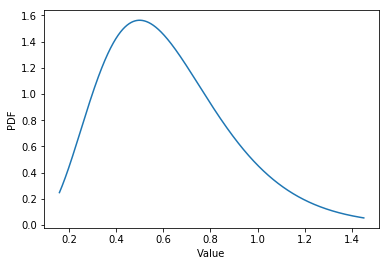

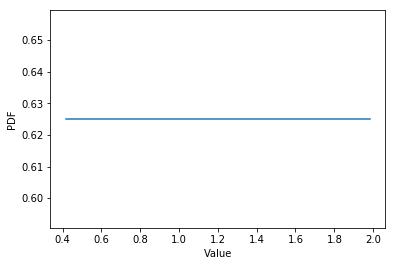

In [2]:
gamma = Gamma(alpha=5, beta=8)
gamma.plot()

uniform = Uniform(lower=0.4, upper=2.0)
uniform.plot()

They can also represent a set of coefficients. For example, the Gaussian channel weighting module takes the set of input channels, weights them using a Gaussian function, and then sums the weighted channels to produce a single output channel. The Gaussian is specified by a mean, `mu`, and standard deviation, `sd`.

The channel weighting module can produce multiple outputs (each weighted using a Gaussian function). However, we would expect that the output channels are somewhat evenly distributed across the rang eof input channels. Assuming that the input channels are normalized to the range [0, 1] where 0 is the lowest-frequency input channel and 1 is the highest-frequency input channel, we can define a set of priors that indicate that we want `mu` for the first input channel to fall at the lower end of the range and `mu` for the last input channel to fall at the upper end of the range.

In [3]:
# Initialize the module with three outputs
wc = WeightChannelsGaussian(3)

# For this particular module, the generation of priors does not
# require any actual data, so we can get away with providing fake
# data.
wc_priors = wc.get_priors(signals)
print(wc_priors)

{'mu': Beta(α=array(3), β=array(3)), 'sd': HalfNormal(σ=array(3))}


As shown above, the weight channels module returned a set of two priors (one for `mu` and one for `sd`). Each set of priors is an array of shape `(3,)` (i.e., a 1D array of 3 elements). Each entry in the array corresponds to one of the output channels.

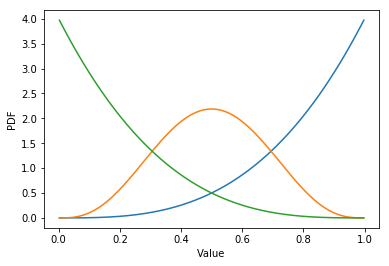

In [4]:
wc_priors['mu'].plot()

As shown in the plot above, the probabilities for each channel are weighted such that they are distributed fairly well along the normalized range of input channels. However, we don't require that channel 1 have a mean value that is less than channel 2 or 3.

We can also create priors with multidimensional coefficients. This is useful in the case of the n-tap FIR filter which takes multiple input channels. The number of coefficients for the FIR filter is the number of inputs times the number of taps. 

In [5]:
n_inputs = 3
n_taps = 7
mu = np.zeros((n_inputs, n_taps))
sd = np.full((n_inputs, n_taps), 5)
coefficient_prior = Normal(mu, sd)

We can get the mean (i.e., expected) value of each coefficient or draw a random sample from each distribution. This can be useful for initializing the fitter.

In [6]:
coefficient_prior.mean()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
coefficient_prior.sample()

array([[-2.63, -1.69, -0.38, -4.98, -1.09, -5.09,  2.67],
       [ 3.03,  4.17,  2.97,  6.34, -2.88,  2.82,  0.05],
       [ 1.12, -0.68, -1.42,  5.18, -2.9 ,  8.62, -2.85]])

Note that these methods return data in the same shape as the set of coefficients specified by the prior. This makes it easy to generate initial data in the correct shape required by the model and module evaluation system.

We can also draw more than one sample. Let's go back to the priors for the weight channels module.

In [8]:
samples = wc_priors['mu'].sample(10000)
samples.shape

(10000, 3)

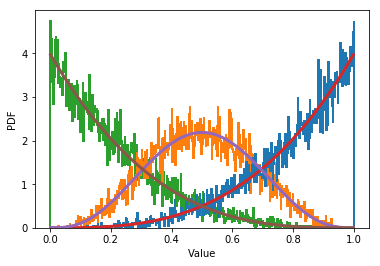

In [9]:
figure, ax = pl.subplots(1, 1)
ax.hist(samples, bins=500, normed=1, histtype='step', lw=2)
wc_priors['mu'].plot(ax=ax, lw=3)

# How distributions work with the NEMS model/module system

We have discussed how to specify distributions for a coefficient. However, how might we use these in the actual NEMS fit process? For Bayesian fitting algorithms, the priors would become part of the actual fit itself. For standard descent algorithms (e.g., those provided by `scipy.optimize`), we can't use the distributions directly. 

Let's build a rudimentary linear STRF model. Note that the FIR module knows that it will be getting two input channels because the `model.get_priors` method asks each module to transform the input data appropriately. The channel weighting collapses the 18 channels in the input data to two channels, which are then fed to the FIR filter so it can generate an appropriate set of priors.

This approach (i.e., allowing the modules to inspect the data before generating a set of priors) allows the modules to specify some reasonable starting points for the fitting process.

In [10]:
model = Model()
model.append(WeightChannelsGaussian(2))
model.append(FIR(n_taps=10))

priors = model.get_priors(signals)
priors

[{'mu': Beta(α=array(2), β=array(2)), 'sd': HalfNormal(σ=array(2))},
 {'coefficients': Normal(μ=array(2, 10), σ=array(2, 10))}]

Here, `model.get_priors` returns a list of dictionaries. Each entry in the list matches the corresponding module. The dictionary is the set of coefficients for that module. If a module has no coefficients, then the dictionary will be empty.

We can use this to generate some reasonable constraints for our model fitting system. For example, let's compute the starting value of `phi` for fitting (the actual coefficient values).

In [11]:
phi = []
for module_priors in priors:
    module_phi = {}
    for name, prior in module_priors.items():
        module_phi[name] = prior.mean()
    phi.append(module_phi)
    
# Starting values for the FIR coefficients
print('Initial value for FIR coefficients: \n', phi[1]['coefficients'])

Initial value for FIR coefficients: 
 [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]


Now, let's get the lower bound for each coefficient using the percentile.

In [12]:
phi_lower = []
for module_priors in priors:
    module_phi = {}
    for name, prior in module_priors.items():
        module_phi[name] = prior.percentile(0)
    phi_lower.append(module_phi)
    
print('Lower bound for weight channels mu: \n', phi_lower[0]['mu'])
print('Lower bound for FIR coefficients: \n', phi_lower[1]['coefficients'])

Lower bound for weight channels mu: 
 [ 0.  0.]
Lower bound for FIR coefficients: 
 [[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]


This is a bit broad. It may be better to use a percentile of 0.001 instead.

In [13]:
phi_lower = []
for module_priors in priors:
    module_phi = {}
    for name, prior in module_priors.items():
        module_phi[name] = prior.percentile(0.001)
    phi_lower.append(module_phi)
    
print('Lower bound for weight channels mu: \n', phi_lower[0]['mu'])
print('Lower bound for FIR coefficients: \n', phi_lower[1]['coefficients'])

Lower bound for weight channels mu: 
 [ 0.1  0. ]
Lower bound for FIR coefficients: 
 [[-2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99]
 [-2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99 -2.99]]


This information can be used by fit algorithms that support bounds (such as `scipy.optimize`). The code above has been wrapped up into some utility functions available via `nems.fitters.util`. Some basic fitting algorithms have already been implemented in `nems.fitters.scipy`.